# Homework Set 5

In [1]:
%pylab inline
import pandas as pd
import sys
import fmt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import time


Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 25 days


# Problem 1:

Use the following historical CMT data set for the this problem,

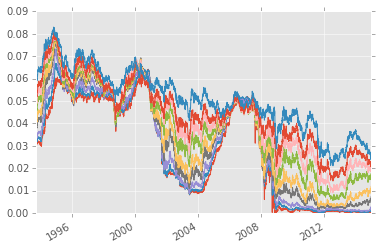

In [2]:
cmturl = "https://raw.githubusercontent.com/yadongli/nyumath2048/master/data/cmt.csv"
cmt_rates = pd.read_csv(cmturl, parse_dates=[0], index_col=[0])*.01

cmt_rates.plot(legend=False);
tenors = cmt_rates.columns.map(float)
tenorTags = ['T=%g' % m for m in tenors]

and suppose today's zero rate term structure is given below, and all rates are continously compounding:

In [3]:
t = map(float, cmt_rates.columns)
r = cmt_rates.iloc[-1, :].values

fmt.displayDF(pd.DataFrame(r, index=t, columns=['Zero Rate (%)']).T*100, fmt="4g")

,0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0,20.0
Zero Rate (%),0.01,0.1,0.26,0.73,1.19,1.75,2.07,2.25,2.54


1. use the tension spline routine from previoius homework to build a tension spline of zero rate term structure $r(t)$ with $\lambda = 5$, you can assume $r(0) = 0$ if needed. Note that we are interpolating the zero rate instead of the cumulative yield here.
2. suppose the liquid market securities (the benchmarks) are 3M deposit (equivalent to zero coupon bond), and swaps paying semi-annual coupons with maturities matching the CMT quotes tenors;  use the curve you built to price these benchmark securities, assuming the deposits are quoted by the continous yield (zero rate) and swaps are quoted in break even spreads (par swap spreads).
3. use your bootstrap functions from the previous homework/lecture to bootstrap the zero rate curve from benchmark quotes from #2, show that the resulting curve is identical to the curve from #1. 
4. You have an aged receiver swap (receiving fixed) on the book with $100M notional, 6Y of remaining maturity and 5% semi-annual fixed coupon. Compute its deltas and hedge notionals to the benchmark instruments by bumping the market quotes of benchmark instruments (ie, deposit and swaps) and re-bootstrapping the IR curve, record the computation time for hedge notionals.
5. Suppose your system only computes the risks to the zero rates, compute the risk of the aged trade to zero rates, and the Jacobian matrix and use them to compute the hedge notionals, compare the results and computation time to the previous step. 

Hint:
* you can use the swap.py library from last homework to price swaps.
* please pay attention to the compounding, there are multiple compounding in this problem: all the zero rates are continuously compounded, the swaps pays coupon semi-annually, therefore the par swap quotes should be computed using the correct coupon frequency. The first deposit is quoted by yield (zero rate), which is countinuously compounded.
* The 3M deposit is equivalent to a 3M swap in risk profile, therefore, you may replace the 3M deposit by a quarterly par swap maturing at 3M as the first benchmark instruments during the bootstrap. It may ease the coding, as you can re-use the same swap pricer. But beware the par swap rate is different from continuous compounded zero rate, thus a proper conversion is required.

## Solution
#### 1.

In [4]:
import lin
t = map(float, cmt_rates.columns)
r = cmt_rates.iloc[-1, :].values
t.insert(0, 0.)
r = np.insert(r, 0, 0.)
x = np.arange(0, 20.01, 0.1)

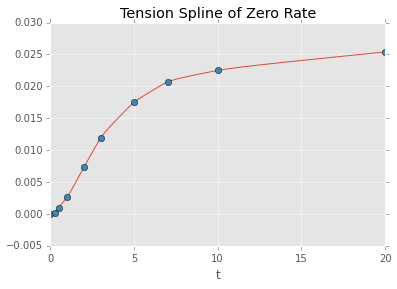

In [5]:
lbd = 5.
ts = lin.RationalTension(lbd)
ts.build(t, r)

plot(x, ts(x))
plot(t, r, 'o')
xlabel('t')
title('Tension Spline of Zero Rate')

#### 2.
The benchmark instrumens' prices are as follows:

In [6]:
from swap import Swap, priceSwap, swapParSpread


def dc(curve) :
    discf = lambda t : np.exp(-t * curve(t))
    return discf


prices = np.zeros(len(t)-1)
prices[0] = r[1]
for i in xrange(1, len(prices)):
    prices[i] = swapParSpread(t[i+1], dc(ts), 2)
hi_names = ['3M ZCB'] + ['Swap @%gY' % i for i in t[2:]] # benchmark instruments


fmt.displayDF(pd.DataFrame([prices], columns=hi_names, index=['Benchmark Instruments']), "3g")

,3M ZCB,Swap @0.5Y,Swap @1Y,Swap @2Y,Swap @3Y,Swap @5Y,Swap @7Y,Swap @10Y,Swap @20Y
Benchmark Instruments,0.0001,0.001,0.0026,0.00729,0.0119,0.0173,0.0204,0.0222,0.0249


#### 3.
The codes for bootstrapping zero rate curve is as follows:

In [7]:
import inst

def y2pv(swap, curve):
    return priceSwap(swap, dc(curve))

bm_ps = {Swap(i, j, 2) : 0 for i, j in zip (t[2:], prices[1:])}
par_3m = 4 * (np.power(np.exp(r[1]*t[1]), 1./(4*t[1])) - 1)
bm_ps[Swap(t[1], par_3m, 4)] = 0 

ts2, e = inst.iterboot(bm_ps, y2pv, x0=0., bds=[-1., 1.], lbd = lbd)


For further comparison, we can use np.allclose
We can see the two curves are identical.

In [9]:
print np.allclose(ts(x), ts2(x))

True


We can also plot them:

(0.0, 0.03)

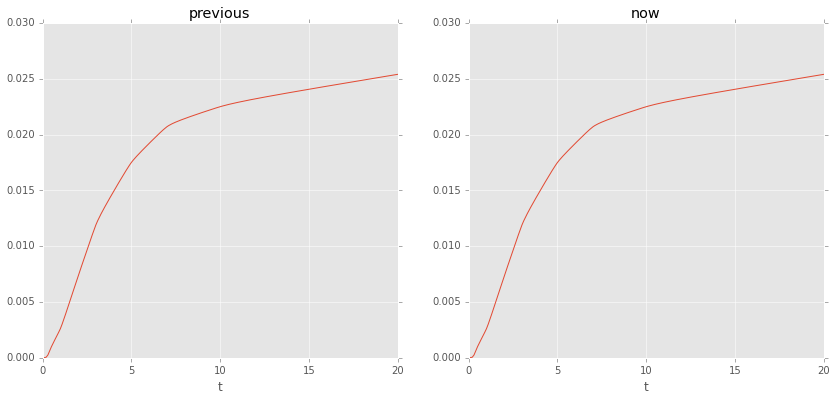

In [8]:
figure(figsize=(14, 6))

subplot(1, 2, 1)
plot(x, ts(x))
title('previous')
xlabel('t')
ylim([0., 0.03])

subplot(1, 2, 2)
plot(x, ts2(x))
title('now')
xlabel('t')
ylim([0., 0.03])

#### 4.
Following codes show the deltas and hedge notionals by re-bootstrapping the IR curve as well as the corresponding computation time.

In [27]:
import inst
import copy
pert = 1e-4
bespoke = Swap(maturity=6., coupon=0.05, freq=2.)
insts = [swap for swap in sorted(bm_ps.keys(), key=lambda x:x.maturity)]
notional = 1e8


In [49]:
# Construct the perturbed curves
start = time.time()

curves = []
count = 0
for k in sorted(bm_ps.keys(), key=lambda x : x.maturity):
    bms_tmp = copy.copy(bm_ps)
    new_key = Swap(k.maturity, k.coupon-pert, k.freq)
    bms_tmp[new_key] = bms_tmp.pop(k)
    curve_tmp, e_tmp = inst.iterboot(bms_tmp, y2pv, x0=0., bds=[-1., 1.], lbd=lbd)
    curves.append(curve_tmp)

# Calculate Deltas, Hedge Notionals, PV01 

n = len(curves)
pv_bespoke = y2pv(bespoke, ts2)
Deltas_1, PV01 = np.zeros(n), np.zeros(n)
for i in xrange(n):
    Deltas_1[i] = y2pv(bespoke, curves[i]) - pv_bespoke
    PV01[i] = y2pv(insts[i], curves[i]) / pert
Hedge_Notionals = - (Deltas_1 / PV01) * notional / pert

time1 = time.time() - start

In [50]:
df1 = [Deltas_1*notional, Hedge_Notionals, PV01]
df1 = pd.DataFrame(df1, columns=hi_names, index=['Deltas', 'Hedge Notionals', 'PV_01'])
fmt.displayDF(df1, "4f")

print "\nComputation time for hedge notionals is: ", time1

,3M ZCB,Swap @0.5Y,Swap @1Y,Swap @2Y,Swap @3Y,Swap @5Y,Swap @7Y,Swap @10Y,Swap @20Y
Deltas,2.6566,56.1822,238.9193,835.7076,-690.3861,"33,467.1140","30,015.6866",-990.4148,10.0360
Hedge Notionals,"-106,262.0595","-1,124,149.4448","-2,392,778.4962","-4,204,417.2574","2,333,714.1072","-69,297,701.3636","-45,486,969.1278","1,091,088.2873","-6,267.4258"
PV_01,0.2500,0.4998,0.9985,1.9877,2.9583,4.8295,6.5987,9.0773,16.0130



Computation time for hedge notionals is:  2.84359097481


#### 5.
Following codes show the calculations of the hedging portfolio and the Jacobian matrix.

The computation time is much less than previous.

In [88]:
import inst
import copy
# Init
t = map(float, cmt_rates.columns)
r = cmt_rates.iloc[-1, :].values
t.insert(0, 0.)
r = np.insert(r, 0, 0.)
lbd, pert = 5., 1e-4

In [47]:
# Construct the perturbed curves
start = time.time()

curves2 = []
for i in xrange(1, len(t)) :   
    r_tmp = copy.copy(r)
    r_tmp[i] -= pert
    curve_tmp = lin.RationalTension(lbd)
    curve_tmp.build(t, r_tmp)
    curves2.append(curve_tmp)

# Calculate Jacobian, Deltas, Hedge Notionals
    
n = len(curves2)
Jacobian = np.zeros((n, n))
Deltas = np.zeros(n)
for i in xrange(n):
    row = np.zeros(n)
    for j in xrange(n):
        row[j] = y2pv(insts[i], curves2[j])
    Jacobian[i, :] = row
    Deltas[i] = (y2pv(bespoke, curves2[i]) - pv_bespoke)
    
Hedge_Ratio = Deltas.dot(np.linalg.inv(Jacobian))

time2 = time.time() - start

In [48]:
print "\nComputation time for hedge notionals is: ", time2
h_r = pd.DataFrame([Deltas*notional, Hedge_Ratio, -Hedge_Ratio*notional], 
                  index=['Deltas', 'Hedge Ratios', 'Hedge Notionals'], columns=hi_names)
fmt.displayDF(h_r, "4f")


Computation time for hedge notionals is:  0.0136890411377


,3M ZCB,Swap @0.5Y,Swap @1Y,Swap @2Y,Swap @3Y,Swap @5Y,Swap @7Y,Swap @10Y,Swap @20Y
Deltas,5.3024,93.3754,435.6493,"1,164.7941",393.6718,"33,259.4719","28,149.5167",-911.4162,8.6436
Hedge Ratios,0.0011,0.0112,0.0239,0.0420,-0.0233,0.6930,0.4549,-0.0109,0.0001
Hedge Notionals,"-106,274.9643","-1,124,235.6391","-2,393,008.3479","-4,204,619.2802","2,333,345.8430","-69,298,869.8647","-45,487,470.1120","1,091,142.2681","-6,268.6851"


In [46]:
print "The Jacobian Matrix is :"

df_jacobian = pd.DataFrame(Jacobian/pert, columns=['Pert %gY' % m for m in t[1:]], index=hi_names)
fmt.displayDF(df_jacobian, "4f")

Jacobian Matrix:


,Pert 0.25Y,Pert 0.5Y,Pert 1Y,Pert 2Y,Pert 3Y,Pert 5Y,Pert 7Y,Pert 10Y,Pert 20Y
3M ZCB,0.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Swap @0.5Y,0.0000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Swap @1Y,0.0000,0.0006,0.9988,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000
Swap @2Y,0.0001,0.0013,0.0069,1.9812,-0.0002,0.0000,-0.0000,0.0000,-0.0000
Swap @3Y,0.0001,0.0022,0.0106,0.0241,2.9193,-0.0002,0.0000,-0.0000,0.0000
Swap @5Y,0.0002,0.0030,0.0162,0.0274,0.0906,4.6746,-0.0029,0.0001,-0.0000
Swap @7Y,0.0003,0.0036,0.0190,0.0333,0.1010,0.1946,6.2018,-0.0024,0.0000
Swap @10Y,0.0003,0.0039,0.0206,0.0358,0.1114,0.1899,0.3739,8.2708,-0.0014
Swap @20Y,0.0003,0.0044,0.0231,0.0408,0.1211,0.2589,0.0395,1.8946,13.3935


## Problem 2

Following what you have done from the first problem, take the zero rates as fundamental risk factors in the market, and the aged bespoke swap:

1. suppose only 1Y, 5Y and 10Y IR swaps are liquid, devise the best hedging portfolio for the aged swap that minimizes the L-2 norm of the risks.
2. repeat step 1, but minimize the variance of the hedged portfolio instead, you can estimate the covariance matrix from the historical data.

Show the effectiveness of your hedging portfolio.

Hint: be careful on whether you should use the covariance of levels or changes of rates.

## (Extra Credit) Problem 3
You now have four hedging portfolios from problem 1, a) a full hedging portfolio using all benchmark instruments b) a partial hedging portfolio that only use the 3 liquid swaps in the hedging portfolio of a, and keeping their notional the same as a, c) use only the three liquid instruments, and minimize the L-2 norm of the hedged risks d) same as c, but minimize the variance of daily PnL.

Now you want to compare the performance of these four hedging strategies, and make a recommendation to your head trader. What your head trader cares the most is to minimize the daily PnL of the hedged portfolios under the following common market scenarios:

1. rough parallel moves in quoted spread, which is the most common mode of movement in the market; the daily rates movements are typically only a few basis points, however, the daily rates movements can be as big as 20bps or more in turmoil market.
2. how the hedges performs if the curve become steeper of flatter.
3. In addition, your head trader wants to know the hedged risk profiles and the projected daily PnL volatiity (standard deviation) with the hedges,

You can use other metrics to help justify your recommendation of the best hedging strategy. You should include the unhedged trade as a reference in your analysis.

Hint: You certainly could directly perscribe the scenarios according to your head trader's description, but it is better to come up an objective and historical data driven way to define these common parallel moves and curve steepener/flatteners scenarios. 

## (Extra credit) Problem 4 
 
The Brownian bridge method can be easily extended to multi-dimensional correlated Brownian motions. Assuming we have two browniam motion $x(t), y(t)$ with a correlation of 50%,

1. write a program to construct correlated Brownian Bridge from the given terminal values, correlation matrix and time increments, note that here you need to draw correlated Gaussian random numbers to perserve the correlation of the Brownian Bridge increments.
2. draw multiple paths from different terminal values and verify that the correlation of the increments of your Brownian Bridge is indeed 50%. Note that the terminal values can be drawn directly using the covariance matrix, which is known. 
3. suppose that you forgot about the correlation and used independent Gaussian random numbers in step 1, and have drawn the Brownian Bridges using correlated terminal values, but independent increments; Plot the resulting terminal value correlation between $\rho\left(x(t), y(t)\right)$ of the resulting Brownian Bridge over time $t$, explain your observation.